In [1]:
import os
# numerical computing package
import numpy as np
# 
from scipy import stats
# command style functions that make matplotlib work like MATLAB
import matplotlib.pyplot as plt
# matplotlib
import matplotlib
# find nearest value
def find_nearest_index(array, value):
    return (np.abs(array - value)).argmin()
#
import sys
#
import pickle
#
import xarray as xr
#
from glob import glob as gb
#
import time
#
import cartopy.crs as ccrs

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
%%javascript
IPython.notebook.kernel.execute('nb_name = ' + '"' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [3]:
!pwd

/home/561/erd561/mom/gfdl_nyf_1080_rcp85


In [4]:
figures_path = '/home/561/erd561/figures/SAMexp/'
script_name = nb_name[:-6]
print('Figures will be saved in: ' + figures_path + script_name + '\n')

nyf_path = '/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/'
ctrl_path = '/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/'
hist5069_path = '/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/'
rcp85_path = '/g/data/e14/erd561/mom/gfdl_nyf_1080_rcp85/archive/'




Figures will be saved in: /home/561/erd561/figures/SAMexp/t04_anomalies



In [5]:
%%time

from dask.distributed import Client
c = Client()
print(c)

<Client: scheduler='tcp://127.0.0.1:37940' processes=8 cores=8>
CPU times: user 1.48 s, sys: 312 ms, total: 1.79 s
Wall time: 14.5 s


In [6]:
# ice_daily, ice_month, ocean_bgc_2d, ocean_bgc_carbon, ocean_bgc_daily,
# ocean_bgc_npzd, ocean_cfc, ocean_force, ocean_global, ocean_month, ocean_surface

nyf_years = np.arange(477, 487)
ctrl_years = np.arange(566, 576)
# hist5069_years = np.arange(501, 576)
rcp85_years = np.arange(611, 621)

nyf_years_len = len(nyf_years)
ctrl_years_len = len(ctrl_years)
# hist5069_years_len = len(hist5069_years)
rcp85_years_len = len(rcp85_years)

years = np.concatenate([
    np.arange(1-nyf_years_len, 0), 
    np.arange(0, ctrl_years_len+1), 
    np.arange(ctrl_years_len+1, ctrl_years_len+1 + rcp85_years_len)])
print(years)
print(len(years))

# 1. SST
var1 = 'ice_month'
path1 = []

# 2. tx and ty trans
var21 = 'ocean'
var22 = 'ocean_month'
path2 = []

# var31 = 'ocean'
# var32 = 'ocean_month'
# path3 = []

for y in nyf_years:
    path1.append(nyf_path + 'output' + str(y) + '/' + var21 + '.nc')
    path2.append(nyf_path + 'output' + str(y) + '/' + var21 + '.nc')
#     path3.append(remote_path_ctrl + 'output' + str(y) + '/' + var31 + '.nc')

for y in ctrl_years:
    path1.append(ctrl_path + 'output' + str(y) + '/' + var22 + '.nc')
    path2.append(ctrl_path + 'output' + str(y) + '/' + var22 + '.nc')
#     path3.append(remote_path + 'output' + str(y) + '/' + var32 + '.nc')

for y in rcp85_years:
    path1.append(rcp85_path + 'output' + str(y) + '/' + var22 + '.nc')
    path2.append(rcp85_path + 'output' + str(y) + '/' + var22 + '.nc')
#     path3.append(remote_path + 'output' + str(y) + '/' + var32 + '.nc')


for p1,p2 in zip(path1,path2):
    print(p1)
    print(p2)
#     print(p3)


[-9 -8 -7 -6 -5 -4 -3 -2 -1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14
 15 16 17 18 19 20]
30
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output477/ocean.nc
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output477/ocean.nc
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output478/ocean.nc
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output478/ocean.nc
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output479/ocean.nc
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output479/ocean.nc
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output480/ocean.nc
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output480/ocean.nc
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output481/ocean.nc
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output481/ocean.nc
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output482/ocean.nc
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output482/ocean.nc
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output483/ocean.nc
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output483/ocean.nc
/g/data/

In [7]:
%%time

lon = [100-360, 170-360]
lat = [-60, -20]

for p1,p2 in zip(path1, path2):
    if p1 == path1[0]:
        SST = \
            xr.open_dataset(p1, decode_times=False).\
            temp.\
            sel(xt_ocean=slice(lon[0], lon[1])).\
            sel(yt_ocean=slice(lat[0], lat[1])).\
            sel(st_ocean=0, method='nearest').\
            drop(('geolon_t', 'geolat_t')).\
            mean(dim='time')
        
        tau_x = \
            xr.open_dataset(p2, decode_times=False).\
            tau_x.\
            sel(xu_ocean=slice(lon[0], lon[1])).\
            sel(yu_ocean=slice(lat[0], lat[1])).\
            mean(dim='time').\
            drop(('geolon_c', 'geolat_c'))
        
        sea_level = \
            xr.open_dataset(p2, decode_times=False).\
            sea_level.\
            sel(xt_ocean=slice(lon[0], lon[1])).\
            sel(yt_ocean=slice(lat[0], lat[1])).\
            mean(dim='time').\
            drop(('geolon_t', 'geolat_t'))*100
        
        print(str(p1) + ' OK')
            
    elif 'v45' in p1:
        SST = \
            xr.concat([
                SST,
                xr.open_dataset(p1, decode_times=False).\
                temp.\
                sel(xt_ocean=slice(lon[0], lon[1])).\
                sel(yt_ocean=slice(lat[0], lat[1])).\
                sel(st_ocean=0, method='nearest').\
                drop(('geolon_t', 'geolat_t')).\
                mean(dim='time')
            ], 'year'
            )
        
        tau_x = \
            xr.concat([
                tau_x,
                xr.open_dataset(p2, decode_times=False).\
                tau_x.\
                sel(xu_ocean=slice(lon[0], lon[1])).\
                sel(yu_ocean=slice(lat[0], lat[1])).\
                mean(dim='time').\
                drop(('geolon_c', 'geolat_c'))
            ], 'year'
            )
        
        sea_level = \
            xr.concat([
                sea_level,
                xr.open_dataset(p2, decode_times=False).\
                sea_level.\
                sel(xt_ocean=slice(lon[0], lon[1])).\
                sel(yt_ocean=slice(lat[0], lat[1])).\
                mean(dim='time').\
                drop(('geolon_t', 'geolat_t'))*100
            ], 'year'
            )
        
        print(str(p1) + ' OK')
        
    else:
        SST = \
            xr.concat([
                SST,
                xr.open_dataset(p1, decode_times=False).\
                temp.\
                sel(xt_ocean=slice(lon[0], lon[1])).\
                sel(yt_ocean=slice(lat[0], lat[1])).\
                sel(st_ocean=0, method='nearest').\
                mean(dim='time')
            ], 'year'
            )
        tau_x = \
            xr.concat([
                tau_x,
                xr.open_dataset(p2, decode_times=False).\
                tau_x.\
                sel(xu_ocean=slice(lon[0], lon[1])).\
                sel(yu_ocean=slice(lat[0], lat[1])).\
                mean(dim='time')
            ], 'year'
            )
        sea_level = \
            xr.concat([
                sea_level,
                xr.open_dataset(p2, decode_times=False).\
                sea_level.\
                sel(xt_ocean=slice(lon[0], lon[1])).\
                sel(yt_ocean=slice(lat[0], lat[1])).\
                mean(dim='time')*100
            ], 'year'
            )
        print(str(p1) + ' OK')
print(SST)

xt_ocean = SST.xt_ocean
xt_ocean_corrected = xt_ocean + 360
SST = SST.assign_coords(xt_ocean=xt_ocean_corrected)
xu_ocean = tau_x.xu_ocean
xu_ocean_corrected = xu_ocean + 360
tau_x = tau_x.assign_coords(xu_ocean=xu_ocean_corrected)
sea_level = sea_level.assign_coords(xt_ocean=xt_ocean_corrected)

SST = SST.assign_coords(year=years)
tau_x = tau_x.assign_coords(year=years)
sea_level = sea_level.assign_coords(year=years)

/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output477/ocean.nc OK
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output478/ocean.nc OK
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output479/ocean.nc OK
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output480/ocean.nc OK
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output481/ocean.nc OK
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output482/ocean.nc OK
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output483/ocean.nc OK
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output484/ocean.nc OK
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output485/ocean.nc OK
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output486/ocean.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output566/ocean_month.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output567/ocean_month.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output568/ocean_month.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output569/ocean_month.nc O

In [8]:
%%time

lon = [100-360, 170-360]
lat = [-60, -20]

for p1,p2 in zip(path1, path2):
    if p1 == path1[0]:
        u = \
            xr.open_dataset(p2, decode_times=False).\
            u.\
            sel(xu_ocean=slice(lon[0], lon[1])).\
            sel(yu_ocean=slice(lat[0], lat[1])).\
            sel(st_ocean=0, method='nearest').\
            mean(dim='time').\
            drop(('geolon_c', 'geolat_c'))*100
        
        v = \
            xr.open_dataset(p2, decode_times=False).\
            v.\
            sel(xu_ocean=slice(lon[0], lon[1])).\
            sel(yu_ocean=slice(lat[0], lat[1])).\
            sel(st_ocean=0, method='nearest').\
            mean(dim='time').\
            drop(('geolon_c', 'geolat_c'))*100
        
        print(str(p1) + ' OK')
            
    elif 'v45' in p1:
        u = \
            xr.concat([
                u,
                xr.open_dataset(p2, decode_times=False).\
                u.\
                sel(xu_ocean=slice(lon[0], lon[1])).\
                sel(yu_ocean=slice(lat[0], lat[1])).\
                sel(st_ocean=0, method='nearest').\
                mean(dim='time').\
                drop(('geolon_c', 'geolat_c'))*100
            ], 'year'
            )
        
        v = \
            xr.concat([
                v,
                xr.open_dataset(p2, decode_times=False).\
                v.\
                sel(xu_ocean=slice(lon[0], lon[1])).\
                sel(yu_ocean=slice(lat[0], lat[1])).\
                sel(st_ocean=0, method='nearest').\
                mean(dim='time').\
                drop(('geolon_c', 'geolat_c'))*100
            ], 'year'
            )
        
        print(str(p1) + ' OK')
        
    else:
        u = \
            xr.concat([
                u,
                xr.open_dataset(p2, decode_times=False).\
                u.\
                sel(xu_ocean=slice(lon[0], lon[1])).\
                sel(yu_ocean=slice(lat[0], lat[1])).\
                sel(st_ocean=0, method='nearest').\
                mean(dim='time')*100
            ], 'year'
            )
        
        v = \
            xr.concat([
                v,
                xr.open_dataset(p2, decode_times=False).\
                v.\
                sel(xu_ocean=slice(lon[0], lon[1])).\
                sel(yu_ocean=slice(lat[0], lat[1])).\
                sel(st_ocean=0, method='nearest').\
                mean(dim='time')*100
            ], 'year'
            )
        
        print(str(p1) + ' OK')
print(u)
print(v)

u = u.assign_coords(xu_ocean=xu_ocean_corrected)
v = v.assign_coords(xu_ocean=xu_ocean_corrected)

u = u.assign_coords(year=years)
v = v.assign_coords(year=years)

/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output477/ocean.nc OK
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output478/ocean.nc OK
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output479/ocean.nc OK
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output480/ocean.nc OK
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output481/ocean.nc OK
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output482/ocean.nc OK
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output483/ocean.nc OK
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output484/ocean.nc OK
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output485/ocean.nc OK
/g/data/v45/pas561/mom/archive/gfdl_nyf_1080/output486/ocean.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output566/ocean_month.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output567/ocean_month.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output568/ocean_month.nc OK
/g/data/e14/erd561/mom/gfdl_nyf_1080_hist_5069/archive/output569/ocean_month.nc O

In [9]:
SST_nyf = SST.sel(year=slice(-9,0)).mean(dim='year')
SST_hist5069 = SST.sel(year=slice(1,10)).mean(dim='year')
SST_rcp85 = SST.sel(year=slice(11,20)).mean(dim='year')

tau_x_nyf = tau_x.sel(year=slice(-9,0)).mean(dim='year')
tau_x_hist5069 = tau_x.sel(year=slice(1,10)).mean(dim='year')
tau_x_rcp85 = tau_x.sel(year=slice(11,20)).mean(dim='year')

sea_level_nyf = sea_level.sel(year=slice(-9,0)).mean(dim='year')
sea_level_hist5069 = sea_level.sel(year=slice(1,10)).mean(dim='year')
sea_level_rcp85 = sea_level.sel(year=slice(11,20)).mean(dim='year')

u_nyf = u.sel(year=slice(-9,0)).mean(dim='year')
u_hist5069 = u.sel(year=slice(1,10)).mean(dim='year')
u_rcp85 = u.sel(year=slice(11,20)).mean(dim='year')

v_nyf = v.sel(year=slice(-9,0)).mean(dim='year')
v_hist5069 = v.sel(year=slice(1,10)).mean(dim='year')
v_rcp85 = v.sel(year=slice(11,20)).mean(dim='year')

<xarray.DataArray 'u' (yu_ocean: 132, xu_ocean: 168)>
array([[7.543518, 7.692347, 7.700392, ..., 1.080084, 1.265975, 1.51569 ],
       [8.015501, 8.385604, 8.47611 , ..., 2.064913, 1.962053, 1.892886],
       [6.93604 , 7.332565, 7.451491, ..., 2.665306, 2.321521, 2.00329 ],
       ...,
       [2.547545, 2.076687, 1.346517, ...,      nan,      nan,      nan],
       [1.180668, 1.098639, 0.665012, ...,      nan,      nan,      nan],
       [0.112107, 0.339553, 0.429577, ...,      nan,      nan,      nan]],
      dtype=float32)
Coordinates:
  * xu_ocean  (xu_ocean) float64 105.0 105.2 105.5 105.8 106.0 106.2 106.5 ...
  * yu_ocean  (yu_ocean) float64 -47.08 -46.91 -46.74 -46.57 -46.4 -46.22 ...
    st_ocean  float64 5.034
<xarray.DataArray 'u' (yu_ocean: 132, xu_ocean: 72)>
array([[ 1.580266,  1.471366,  1.251047, ..., -1.198738, -1.299953, -1.414679],
       [ 1.863575,  1.917079,  1.933441, ..., -0.915905, -1.204281, -1.50701 ],
       [ 1.919551,  2.141726,  2.577325, ..., -0.074125, 

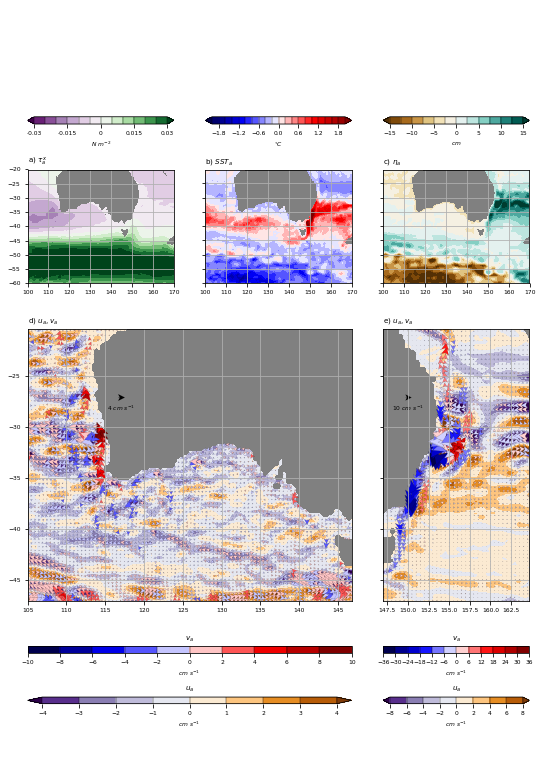

In [120]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
def arange(start,end,stride=1):
    return np.arange(start,end+0.00000001,stride)

fig = plt.figure() 
fig.set_size_inches(7.5,12)
matplotlib.rcParams.update({'font.size': 6}) 
col = 3
row = 5


ax = plt.subplot2grid((row, col), (1, 0), rowspan=1, colspan=1)
cont_lev = arange(-0.03,0.03,0.005)
anom = tau_x_rcp85 - tau_x_hist5069
contf = anom.plot.contourf(add_colorbar=False, levels=cont_lev, cmap=plt.cm.PRGn, extend='both')
plt.grid()
plt.title(r'a) $\tau^{x}_{a}$', loc='left')
plt.xlabel('')
plt.ylabel('')
ax.set_facecolor('gray')
ax = plt.subplot2grid((row, col), (0, 0), rowspan=1, colspan=1)
ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("bottom", size="7%", pad="2%")
cbar = plt.colorbar(contf, cax=cax, orientation='horizontal', drawedges=True)
cbar.set_ticks([-0.03, -0.015, 0, 0.015, 0.03])
cbar.set_ticklabels(['-0.03', '-0.015', '0', '0.015', '0.03'])
cbar.set_label(r'$N\ m^{-2}$') 
ax.axis('off')


ax = plt.subplot2grid((row, col), (1, 1), rowspan=1, colspan=1)
cont_lev = np.arange(-2,2.2,0.2)
anom = SST_rcp85 - SST_hist5069
contf = anom.plot.contourf(add_colorbar=False, levels=cont_lev, cmap=plt.cm.seismic, extend='both')
plt.title('')
plt.grid()
plt.title('b) $SST_{a}$', loc='left')
plt.xlabel('')
plt.ylabel('')
ax.set_facecolor('gray')
plt.gca().set_yticklabels('')
ax = plt.subplot2grid((row, col), (0, 1), rowspan=1, colspan=1)
ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("bottom", size="7%", pad="2%")
cbar = plt.colorbar(contf, cax=cax, orientation='horizontal', drawedges=True)
# cbar.set_ticks([-0.02, -0.01, 0, 0.01, 0.02])
cbar.set_label(r'$^{\circ}C$') 
ax.axis('off')


ax = plt.subplot2grid((row, col), (1, 2), rowspan=1, colspan=1)
cont_lev = arange(-15,15,2.5)
anom = sea_level_rcp85 - sea_level_hist5069
contf = anom.plot.contourf(add_colorbar=False, levels=cont_lev, cmap=plt.cm.BrBG, extend='both')
plt.title('')
plt.grid()
plt.title(r'c) $\eta_{a}$', loc='left')
plt.xlabel('')
plt.ylabel('')
ax.set_facecolor('gray')
plt.gca().set_yticklabels('')
ax = plt.subplot2grid((row, col), (0, 2), rowspan=1, colspan=1)
ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("bottom", size="7%", pad="2%")
cbar = plt.colorbar(contf, cax=cax, orientation='horizontal', drawedges=True)
# cbar.set_ticks([-0.02, -0.01, 0, 0.01, 0.02])
cbar.set_label(r'$cm$') 
ax.axis('off')


ax = plt.subplot2grid((row, col), (2, 0), rowspan=2, colspan=2)
cont_lev = arange(-4, 4, 1)
u_anom = u_rcp85 - u_hist5069
v_anom = v_rcp85 - v_hist5069
X_LIM = [105, 147]
Y_LIM = [-47, -20]
X = v_anom.xu_ocean[
    find_nearest_index(v_anom.xu_ocean.data, X_LIM[0]):find_nearest_index(v_anom.xu_ocean.data, X_LIM[1])]
Y = v_anom.yu_ocean[
    find_nearest_index(v_anom.yu_ocean.data, Y_LIM[0]):find_nearest_index(v_anom.yu_ocean.data, Y_LIM[1])]
# print(X)
# print(Y)
Xm, Ym = np.meshgrid(X,Y)
# print(Xm)
# print(Ym)
U = u_anom[
    find_nearest_index(v_anom.yu_ocean.data, Y_LIM[0]):find_nearest_index(v_anom.yu_ocean.data, Y_LIM[1]),
    find_nearest_index(v_anom.xu_ocean.data, X_LIM[0]):find_nearest_index(v_anom.xu_ocean.data, X_LIM[1])
]
V = v_anom[
    find_nearest_index(v_anom.yu_ocean.data, Y_LIM[0]):find_nearest_index(v_anom.yu_ocean.data, Y_LIM[1]),
    find_nearest_index(v_anom.xu_ocean.data, X_LIM[0]):find_nearest_index(v_anom.xu_ocean.data, X_LIM[1])
]
print(U)
# print(V)
contf = U.plot.contourf(add_colorbar=False, levels=cont_lev, cmap=plt.cm.PuOr_r, extend='both')
plt.title('')
n = 2
vmin=-10
vmax=10.
step=10
Q_lev = np.linspace(vmin, vmax, step+1)
norm = matplotlib.colors.Normalize(vmin=vmin,vmax=vmax,clip=False)
cmap = matplotlib.colors.ListedColormap(plt.cm.seismic(np.linspace(0,1,step)), "name")
Q = plt.quiver(X[np.arange(0,168,n)], Y[np.arange(0,132,n)],
    U[np.arange(0,132,n), np.arange(0,168,n)],
    V[np.arange(0,132,n), np.arange(0,168,n)],
    V[np.arange(0,132,n), np.arange(0,168,n)],
           cmap=cmap, norm=norm,
           width=0.001, scale=200,
           headwidth=100,
           headlength=100,
           headaxislength=75, edgecolor='k', linewidth=0.1)
ref = 4
qk = ax.quiverkey(Q, 117, -27, ref, str(ref) + ' $cm\ s^{-1}$', labelpos='S',
                   coordinates='data')
plt.grid()
plt.title('d) $u_{a},v_{a}$', loc='left')
plt.xlabel('')
plt.ylabel('')
ax.set_facecolor('gray')
ax = plt.subplot2grid((row, col), (4, 0), rowspan=1, colspan=2)
ax_divider = make_axes_locatable(ax)
cax1 = ax_divider.append_axes("top", size="12%", pad="2%")
cbar = plt.colorbar(contf, cax=cax1, orientation='horizontal', drawedges=True)
cbar.set_label(r'$cm\ s^{-1}$') 
cbar.ax.set_title('$u_{a}$')
cax2 = ax_divider.append_axes("top", size="12%", pad="80%")
cbar = plt.colorbar(Q, cax=cax2, orientation='horizontal', drawedges=True)
cbar.set_ticks(Q_lev)
cbar.set_label(r'$cm\ s^{-1}$')
cbar.ax.set_title('$v_{a}$')
ax.axis('off')


ax = plt.subplot2grid((row, col), (2, 2), rowspan=2, colspan=1)
cont_lev = arange(-8, 8, 2)
u_anom = u_rcp85 - u_hist5069
v_anom = v_rcp85 - v_hist5069
X_LIM = [147, 165]
X = v_anom.xu_ocean[
    find_nearest_index(v_anom.xu_ocean.data, X_LIM[0]):find_nearest_index(v_anom.xu_ocean.data, X_LIM[1])]
Xm, Ym = np.meshgrid(X,Y)
U = u_anom[
    find_nearest_index(v_anom.yu_ocean.data, Y_LIM[0]):find_nearest_index(v_anom.yu_ocean.data, Y_LIM[1]),
    find_nearest_index(v_anom.xu_ocean.data, X_LIM[0]):find_nearest_index(v_anom.xu_ocean.data, X_LIM[1])
]
V = v_anom[
    find_nearest_index(v_anom.yu_ocean.data, Y_LIM[0]):find_nearest_index(v_anom.yu_ocean.data, Y_LIM[1]),
    find_nearest_index(v_anom.xu_ocean.data, X_LIM[0]):find_nearest_index(v_anom.xu_ocean.data, X_LIM[1])
]
print(U)
contf = U.plot.contourf(add_colorbar=False, levels=cont_lev, cmap=plt.cm.PuOr_r, extend='both')
plt.title('')
vmin=-36
vmax=36.
step=12
Q_lev = np.linspace(vmin, vmax, step+1)
norm = matplotlib.colors.Normalize(vmin=vmin,vmax=vmax,clip=False)
cmap = matplotlib.colors.ListedColormap(plt.cm.seismic(np.linspace(0,1,step)), "name")
Q = plt.quiver(X[np.arange(0,72,n)], Y[np.arange(0,132,n)],
    U[np.arange(0,132,n), np.arange(0,72,n)], 
    V[np.arange(0,132,n), np.arange(0,72,n)],
    V[np.arange(0,132,n), np.arange(0,72,n)],
           cmap=cmap, norm=norm,
           width=0.001, scale=250,
           headwidth=100,
           headlength=100,
           headaxislength=75, edgecolor='k', linewidth=0.1)
ref = 10
qk = ax.quiverkey(Q, 150, -27, ref, str(ref) + ' $cm\ s^{-1}$', labelpos='S',
                   coordinates='data')
plt.grid()
plt.title('e) $u_{a},v_{a}$', loc='left')
plt.xlabel('')
plt.ylabel('')
plt.gca().set_yticklabels('')
ax.set_facecolor('gray')
ax = plt.subplot2grid((row, col), (4, 2), rowspan=1, colspan=1)
ax_divider = make_axes_locatable(ax)
cax1 = ax_divider.append_axes("top", size="12%", pad="2%")
cbar = plt.colorbar(contf, cax=cax1, orientation='horizontal', drawedges=True)
cbar.set_label(r'$cm\ s^{-1}$') 
cbar.ax.set_title('$u_{a}$')
cax2 = ax_divider.append_axes("top", size="12%", pad="80%")
cbar = plt.colorbar(Q, cax=cax2, orientation='horizontal', drawedges=True)
cbar.set_ticks(Q_lev)
cbar.set_label(r'$cm\ s^{-1}$')
cbar.ax.set_title('$v_{a}$')
ax.axis('off')


fig.tight_layout(rect=[0, 0, 1, 0.90])

output_ls = os.listdir(figures_path)
if not script_name:
    script_name = 'test'
elif script_name not in output_ls:
    os.mkdir(figures_path + '/' + script_name)
plt.savefig(figures_path + '/' + script_name + '/' + script_name[0:3] \
            + '_fig1_.png', bbox_inches='tight', dpi=300)

(0.0, 1.0, 0.0, 1.0)

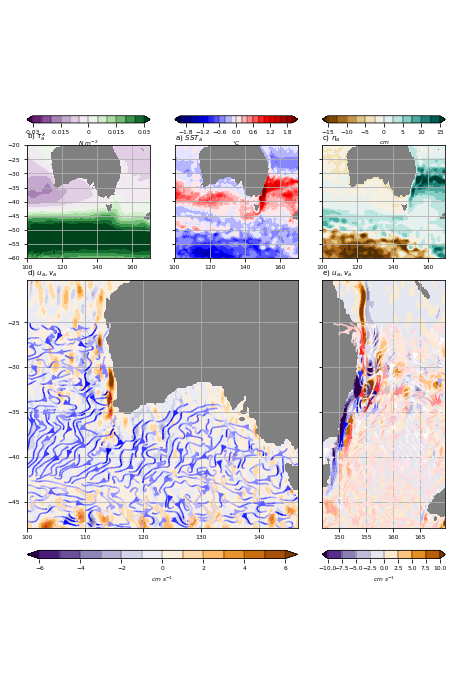

In [438]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
def arange(start,end,stride=1):
    return np.arange(start,end+0.00000001,stride)

fig = plt.figure() 
fig.set_size_inches(7.5,12)
matplotlib.rcParams.update({'font.size': 6}) 
col = 3
row = 5


ax = plt.subplot2grid((row, col), (1, 0), rowspan=1, colspan=1)
cont_lev = arange(-0.03,0.03,0.005)
anom = tau_x_rcp85 - tau_x_hist5069
contf = anom.plot.contourf(add_colorbar=False, levels=cont_lev, cmap=plt.cm.PRGn, extend='both')
plt.grid()
plt.title(r'b) $\tau^{x}_{a}$', loc='left')
plt.xlabel('')
plt.ylabel('')
ax.set_facecolor('gray')
ax = plt.subplot2grid((row, col), (0, 0), rowspan=1, colspan=1)
ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("bottom", size="7%", pad="2%")
cbar = plt.colorbar(contf, cax=cax, orientation='horizontal', drawedges=True)
cbar.set_ticks([-0.03, -0.015, 0, 0.015, 0.03])
cbar.set_ticklabels(['-0.03', '-0.015', '0', '0.015', '0.03'])
cbar.set_label(r'$N\ m^{-2}$') 
ax.axis('off')


ax = plt.subplot2grid((row, col), (1, 1), rowspan=1, colspan=1)
cont_lev = np.arange(-2,2.2,0.2)
anom = SST_rcp85 - SST_hist5069
contf = anom.plot.contourf(add_colorbar=False, levels=cont_lev, cmap=plt.cm.seismic, extend='both')
plt.title('')
plt.grid()
plt.title('a) $SST_{a}$', loc='left')
plt.xlabel('')
plt.ylabel('')
ax.set_facecolor('gray')
plt.gca().set_yticklabels('')
ax = plt.subplot2grid((row, col), (0, 1), rowspan=1, colspan=1)
ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("bottom", size="7%", pad="2%")
cbar = plt.colorbar(contf, cax=cax, orientation='horizontal', drawedges=True)
# cbar.set_ticks([-0.02, -0.01, 0, 0.01, 0.02])
cbar.set_label(r'$^{\circ}C$') 
ax.axis('off')


ax = plt.subplot2grid((row, col), (1, 2), rowspan=1, colspan=1)
cont_lev = arange(-15,15,2.5)
anom = sea_level_rcp85 - sea_level_hist5069
contf = anom.plot.contourf(add_colorbar=False, levels=cont_lev, cmap=plt.cm.BrBG, extend='both')
plt.title('')
plt.grid()
plt.title(r'c) $\eta_{a}$', loc='left')
plt.xlabel('')
plt.ylabel('')
ax.set_facecolor('gray')
plt.gca().set_yticklabels('')
ax = plt.subplot2grid((row, col), (0, 2), rowspan=1, colspan=1)
ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("bottom", size="7%", pad="2%")
cbar = plt.colorbar(contf, cax=cax, orientation='horizontal', drawedges=True)
# cbar.set_ticks([-0.02, -0.01, 0, 0.01, 0.02])
cbar.set_label(r'$cm$') 
ax.axis('off')


ax = plt.subplot2grid((row, col), (2, 0), rowspan=2, colspan=2)
u_anom = u_rcp85 - u_hist5069
v_anom = v_rcp85 - v_hist5069
X_LIM = [100, 147]
Y_LIM = [-48, -20]
X = v_anom.xu_ocean[
    find_nearest_index(v_anom.xu_ocean.data, X_LIM[0]):find_nearest_index(v_anom.xu_ocean.data, X_LIM[1])]
Y = v_anom.yu_ocean[
    find_nearest_index(v_anom.yu_ocean.data, Y_LIM[0]):find_nearest_index(v_anom.yu_ocean.data, Y_LIM[1])]
# print(X)
# print(Y)
Xm, Ym = np.meshgrid(X,Y)
# print(Xm)
# print(Ym)
U = u_anom[
    find_nearest_index(v_anom.yu_ocean.data, Y_LIM[0]):find_nearest_index(v_anom.yu_ocean.data, Y_LIM[1]),
    find_nearest_index(v_anom.xu_ocean.data, X_LIM[0]):find_nearest_index(v_anom.xu_ocean.data, X_LIM[1])
]
V = v_anom[
    find_nearest_index(v_anom.yu_ocean.data, Y_LIM[0]):find_nearest_index(v_anom.yu_ocean.data, Y_LIM[1]),
    find_nearest_index(v_anom.xu_ocean.data, X_LIM[0]):find_nearest_index(v_anom.xu_ocean.data, X_LIM[1])
]
# print(U)
# print(V)
cont_lev = arange(-6, 6, 1)
contf = V.plot.contourf(add_colorbar=False, levels=cont_lev, cmap=plt.cm.PuOr_r, extend='both')
plt.title('')
plt.streamplot(
    Xm,
    Ym,
    U, 
    V,
    color=V.data,
    density=2,
    cmap='seismic')
plt.grid()
plt.title('d) $u_{a},v_{a}$', loc='left')
plt.xlabel('')
plt.ylabel('')
ax.set_facecolor('gray')
ax = plt.subplot2grid((row, col), (4, 0), rowspan=1, colspan=2)
ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("top", size="8%", pad="2%")
cbar = plt.colorbar(contf, cax=cax, orientation='horizontal', drawedges=True)
# cbar.set_ticks([-0.02, -0.01, 0, 0.01, 0.02])
cbar.set_label(r'$cm\ s^{-1}$') 
ax.axis('off')


ax = plt.subplot2grid((row, col), (2, 2), rowspan=2, colspan=1)
u_anom = u_rcp85 - u_hist5069
v_anom = v_rcp85 - v_hist5069
X_LIM = [147, 170]
X = v_anom.xu_ocean[
    find_nearest_index(v_anom.xu_ocean.data, X_LIM[0]):find_nearest_index(v_anom.xu_ocean.data, X_LIM[1])]
Xm, Ym = np.meshgrid(X,Y)
U = u_anom[
    find_nearest_index(v_anom.yu_ocean.data, Y_LIM[0]):find_nearest_index(v_anom.yu_ocean.data, Y_LIM[1]),
    find_nearest_index(v_anom.xu_ocean.data, X_LIM[0]):find_nearest_index(v_anom.xu_ocean.data, X_LIM[1])
]
V = v_anom[
    find_nearest_index(v_anom.yu_ocean.data, Y_LIM[0]):find_nearest_index(v_anom.yu_ocean.data, Y_LIM[1]),
    find_nearest_index(v_anom.xu_ocean.data, X_LIM[0]):find_nearest_index(v_anom.xu_ocean.data, X_LIM[1])
]
cont_lev = arange(-10, 10, 2.5)
contf = V.plot.contourf(add_colorbar=False, levels=cont_lev, cmap=plt.cm.PuOr_r, extend='both')
plt.title('')
plt.streamplot(
    Xm,
    Ym,
    U, 
    V,
    color=V.data,
    density=2,
    cmap='seismic')
plt.grid()
plt.title('e) $u_{a},v_{a}$', loc='left')
plt.xlabel('')
plt.ylabel('')
plt.gca().set_yticklabels('')
ax.set_facecolor('gray')
ax = plt.subplot2grid((row, col), (4, 2), rowspan=1, colspan=1)
ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("top", size="8%", pad="2%")
cbar = plt.colorbar(contf, cax=cax, orientation='horizontal', drawedges=True)
# cbar.set_ticks([-0.02, -0.01, 0, 0.01, 0.02])
cbar.set_label(r'$cm\ s^{-1}$') 
ax.axis('off')


# fig.tight_layout(rect=[0, 0, 1, 0.90])

# output_ls = os.listdir(figures_path)
# if not script_name:
#     script_name = 'test'
# elif script_name not in output_ls:
#     os.mkdir(figures_path + '/' + script_name)
# plt.savefig(figures_path + '/' + script_name + '/' + script_name[0:3] \
#             + '_fig1_.png', bbox_inches='tight', dpi=200)